https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import pathlib
from IPython import display

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )

182082353/182082353 [==============================] - 6s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print(f'Commands: {commands}')

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print(f'Number of total examples: {num_samples}')
print(f'Number of examples per label: {len(tf.io.gfile.listdir(str(data_dir / commands[0])))}')
print(f'Example file tensor: {filenames[0]}')

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: b'data\\mini_speech_commands\\no\\b843de62_nohash_1.wav'


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400:6400 + 800]
test_files = filenames[-800:]

print(f'Training set size: {len(train_files)}')
print(f'Validation set size: {len(val_files)}')
print(f'Test set size: {len(test_files)}')

Training set size: 6400
Validation set size: 800
Test set size: 800


In [6]:
test_file = tf.io.read_file(DATASET_PATH + '/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to 'float32' tensors, normalized to the [-1.0, 1.0] range. Return 'float32' audio and a sample rate
    audio, _ = tf.audio.decode_wav(contents=audio_binary)

    # Since all the data is single channel (mono), drop the 'channels' axis from the array
    return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep
    )

    # Note: You'll use indexing here instead of tuple unpacking to enable this to work in a tensorflow graph
    return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

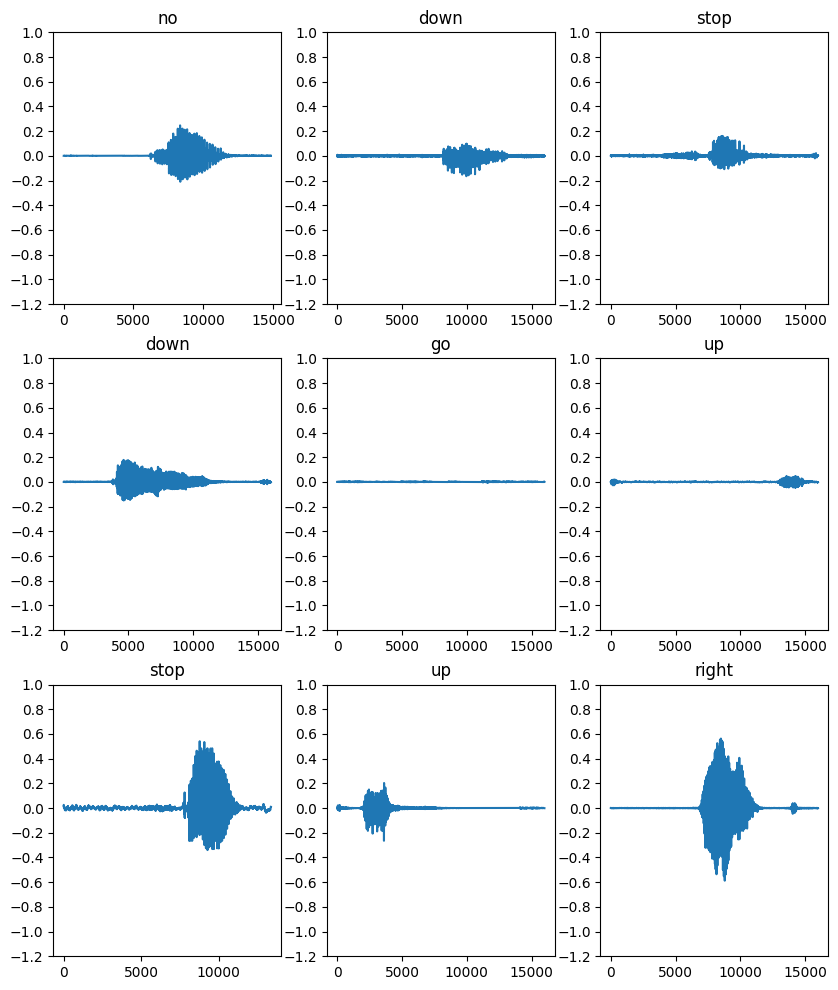

In [11]:
rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))

    label = label.numpy().decode('utf-8')

    ax.set_title(label)

plt.show()

In [12]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16000 samples
    input_len = 16000
    waveform = waveform[:input_len]

    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32
    )

    # Cast the waveform tensors' dtype to float32
    waveform = tf.cast(waveform, dtype=tf.float32)

    # Concatenate the waveform with 'zero_padding', which ensures all audio clips are of the same lenght
    equal_length = tf.concat([waveform, zero_padding], 0)

    # Conver the waveform to a spectrogram vis a STFT
    spectrogram = tf.signal.stft(
        equal_length,
        frame_length=255,
        frame_step=128
    )

    # Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # Add a 'channels' dimension, so that the spectrogram can be used as image-like input data with convolution layers which expect shape (batch_size, height, width, channels)
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print(f'Label: {label}')
print(f'Waveform shape: {waveform.shape}')
print(f'Spectrogram shape: {spectrogram.shape}')

print('Audion playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (14861,)
Spectrogram shape: (124, 129, 1)
Audion playback


In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3

        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns). Add an epsilon to avoid taking a log of zero
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]

    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)

    ax.pcolormesh(X, Y, log_spec)

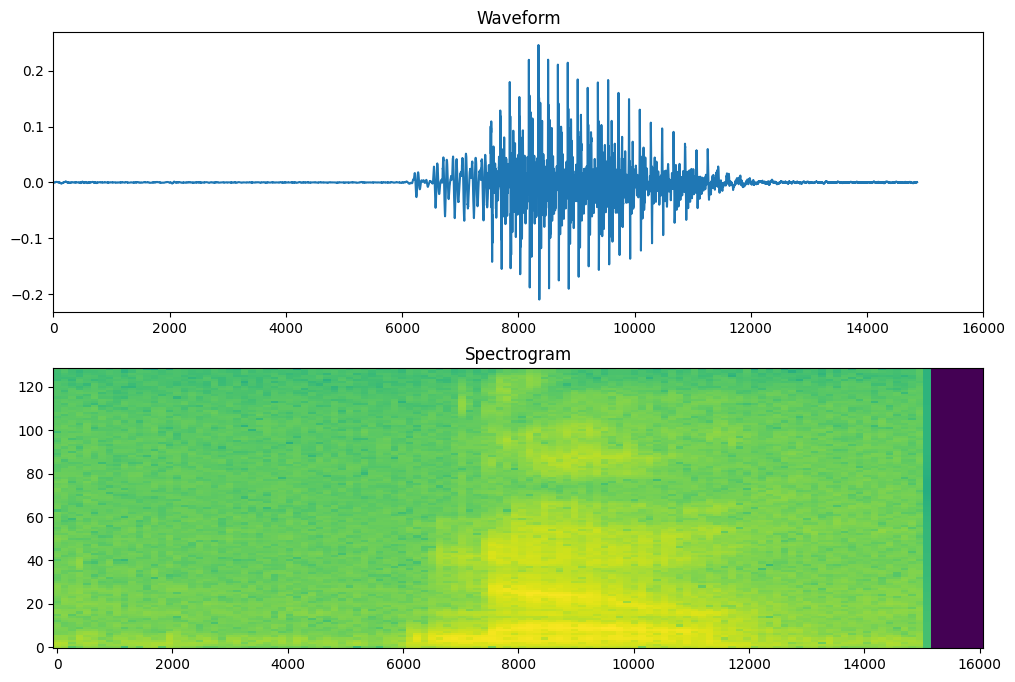

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [16]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id

In [17]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE
)

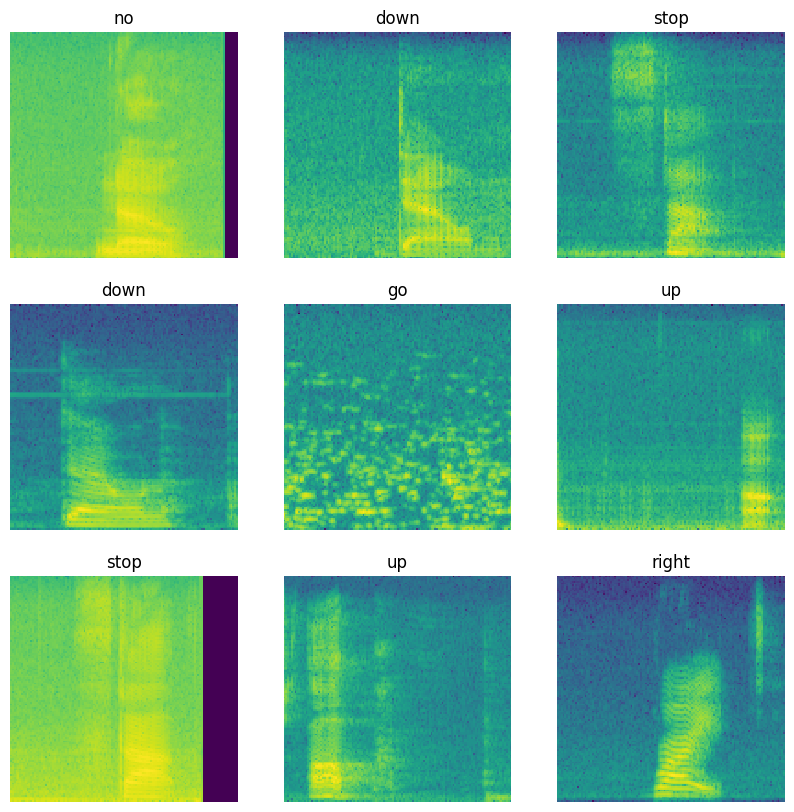

In [18]:
rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_spectrogram(spectrogram.numpy(), ax)

    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [19]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)

    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE
    )

    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE
    )

    return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print(f'Input shape: {input_shape}')

num_labels = len(commands)

# Instantiate the 'tf.keras.layers.Normalization' layer
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms with 'Normalization.adapt'
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),

    # Downsample the input
    layers.Resizing(32, 32),

    # Normalize
    norm_layer,

    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 10s 31ms/step - loss: 1.7573 - accuracy: 0.3719 - val_loss: 1.2955 - val_accuracy: 0.5913
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.1834 - accuracy: 0.5853 - val_loss: 0.9132 - val_accuracy: 0.7013
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.8944 - accuracy: 0.6856 - val_loss: 0.7258 - val_accuracy: 0.7575
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7366 - accuracy: 0.7473 - val_loss: 0.6576 - val_accuracy: 0.7700
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6308 - accuracy: 0.7756 - val_loss: 0.5759 - val_accuracy: 0.7950
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5477 - accuracy: 0.8092 - val_loss: 0.5258 - val_accuracy: 0.8163
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.4673 - accuracy: 0.8333 - val_loss: 0.5106 - val_accuracy: 0.8200
Epoc

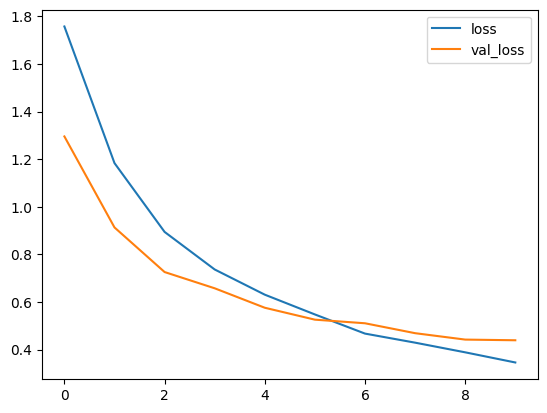

In [26]:
metrics = history.history

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 2ms/step
Test set accuracy: 86%


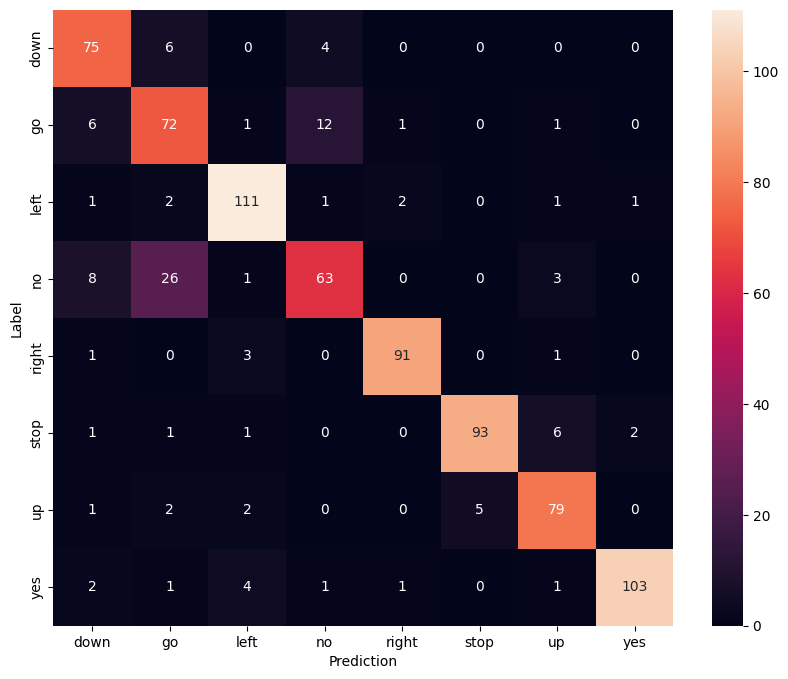

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(
    confusion_mtx,
    xticklabels=commands,
    yticklabels=commands,
    annot=True,
    fmt='g'
)

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

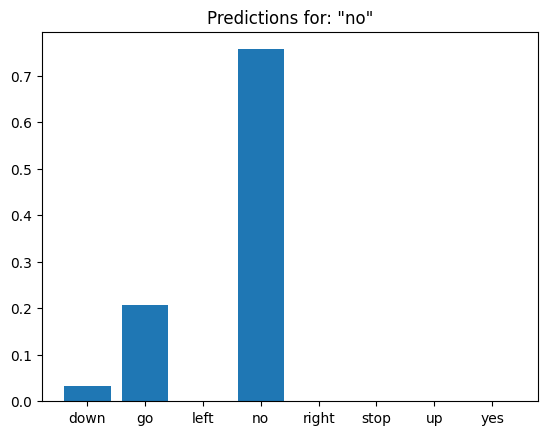

In [30]:
sample_file = data_dir / 'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)

    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for: "{commands[label[0]]}"')
    plt.show()